In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import norm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
%matplotlib inline

# Conduct Time Series Analysis on Average Monthly Jail Population

The source data can be found at `c:/Users/emjoh/OneDrive/Documents/DCJ Analyses/Large_Data/DOC_daily_inmates/DCJ_merged_daily_inmate.csv`. This dataset is the result of stacking the DOC Daily Inmate files. We will aggregate to month and year to predict 12 months in the future. 

### Step 1: Importing merged file and aggregating

In [7]:
merged_df = pd.read_csv('c:/Users/emjoh/OneDrive/Documents/DCJ Analyses/Large_Data/DOC_daily_inmates/DCJ_merged_daily_inmate.csv', index_col= 0)
merged_df.head()

,inmateid,admitted_dt,bradh,inmate_status_code,sealed,srg_flg,infraction,race,gender,age,top_charge,custody_level,snapshot_date
0,20215049,2021-07-26T10:42:40.000,N,DE,N,N,N,NaN,NaN,NaN,NaN,NaN,2021-07-26
1,20211566,2020-10-08T19:35:20.000,N,DE,N,N,N,B,M,24.0,125.25,MED,2021-07-26
2,20200673,2020-10-08T19:54:37.000,N,DE,N,N,N,W,M,38.0,120.05,MED,2021-07-26
3,44737,2020-10-08T20:13:39.000,N,DE,N,N,Y,W,M,42.0,220.39,MED,2021-07-26
4,20177808,2020-10-08T23:53:59.000,Y,DEP,N,Y,Y,B,M,20.0,160.15,MAX,2021-07-26


In [10]:
#first aggregate to day
daily_count = merged_df[['snapshot_date','inmateid']].groupby(by = 'snapshot_date').nunique()
daily_count = daily_count.reset_index()
daily_count['year'] = pd.to_datetime(daily_count['snapshot_date']).dt.year
daily_count['month'] = pd.to_datetime(daily_count['snapshot_date']).dt.month
daily_count.head()

,snapshot_date,inmateid,year,month
0,2021-07-26,5927,2021,7
1,2021-07-27,5900,2021,7
2,2021-07-28,5912,2021,7
3,2021-07-29,5908,2021,7
4,2021-07-30,5873,2021,7


In [12]:
# Group by year and month, calculate mean and standard deviation
monthly_avg = daily_count.groupby(['year', 'month'])['inmateid'].agg(['mean', 'std']).reset_index()
#round columns to the nearest whole number
monthly_avg['mean'] = monthly_avg['mean'].round().astype(int)
monthly_avg['std'] = monthly_avg['std'].fillna(0).round().astype(int)
#rename mean column to Population
monthly_avg = monthly_avg.rename(columns={'mean':'population'})
monthly_avg.head()

,year,month,population,std
0,2021,7,5902,19
1,2021,8,5970,53
2,2021,9,5944,149
3,2021,10,5562,35
4,2021,11,5433,41


### Step 2: Trend-Seasonality-Noise decomposition

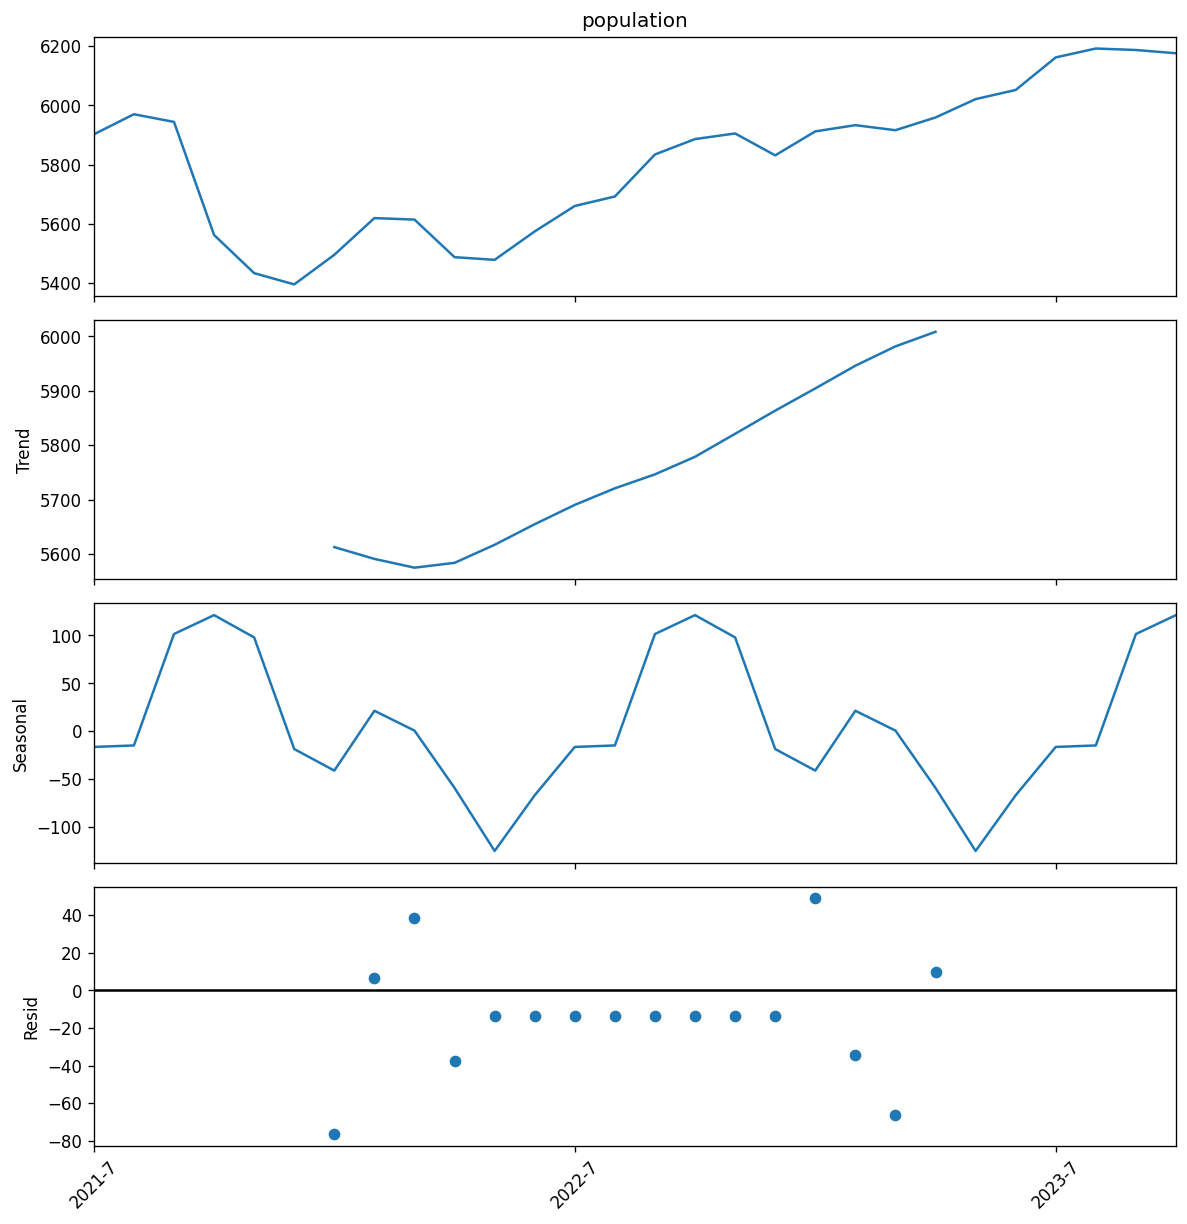

In [13]:
results = seasonal_decompose(monthly_avg['population'],model='additive',period=12)
monthly_avg['Year-Mo'] = ['-'.join(i) for i in zip(monthly_avg["year"].map(str),monthly_avg["month"].map(str))]
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':120})
results.plot()
tick_positions = range(0, len(monthly_avg), 12)
plt.xticks(tick_positions, monthly_avg['Year-Mo'].iloc[tick_positions], rotation=45)
plt.show()

### Step 3: Stationarity and Autocorrelation

#### Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

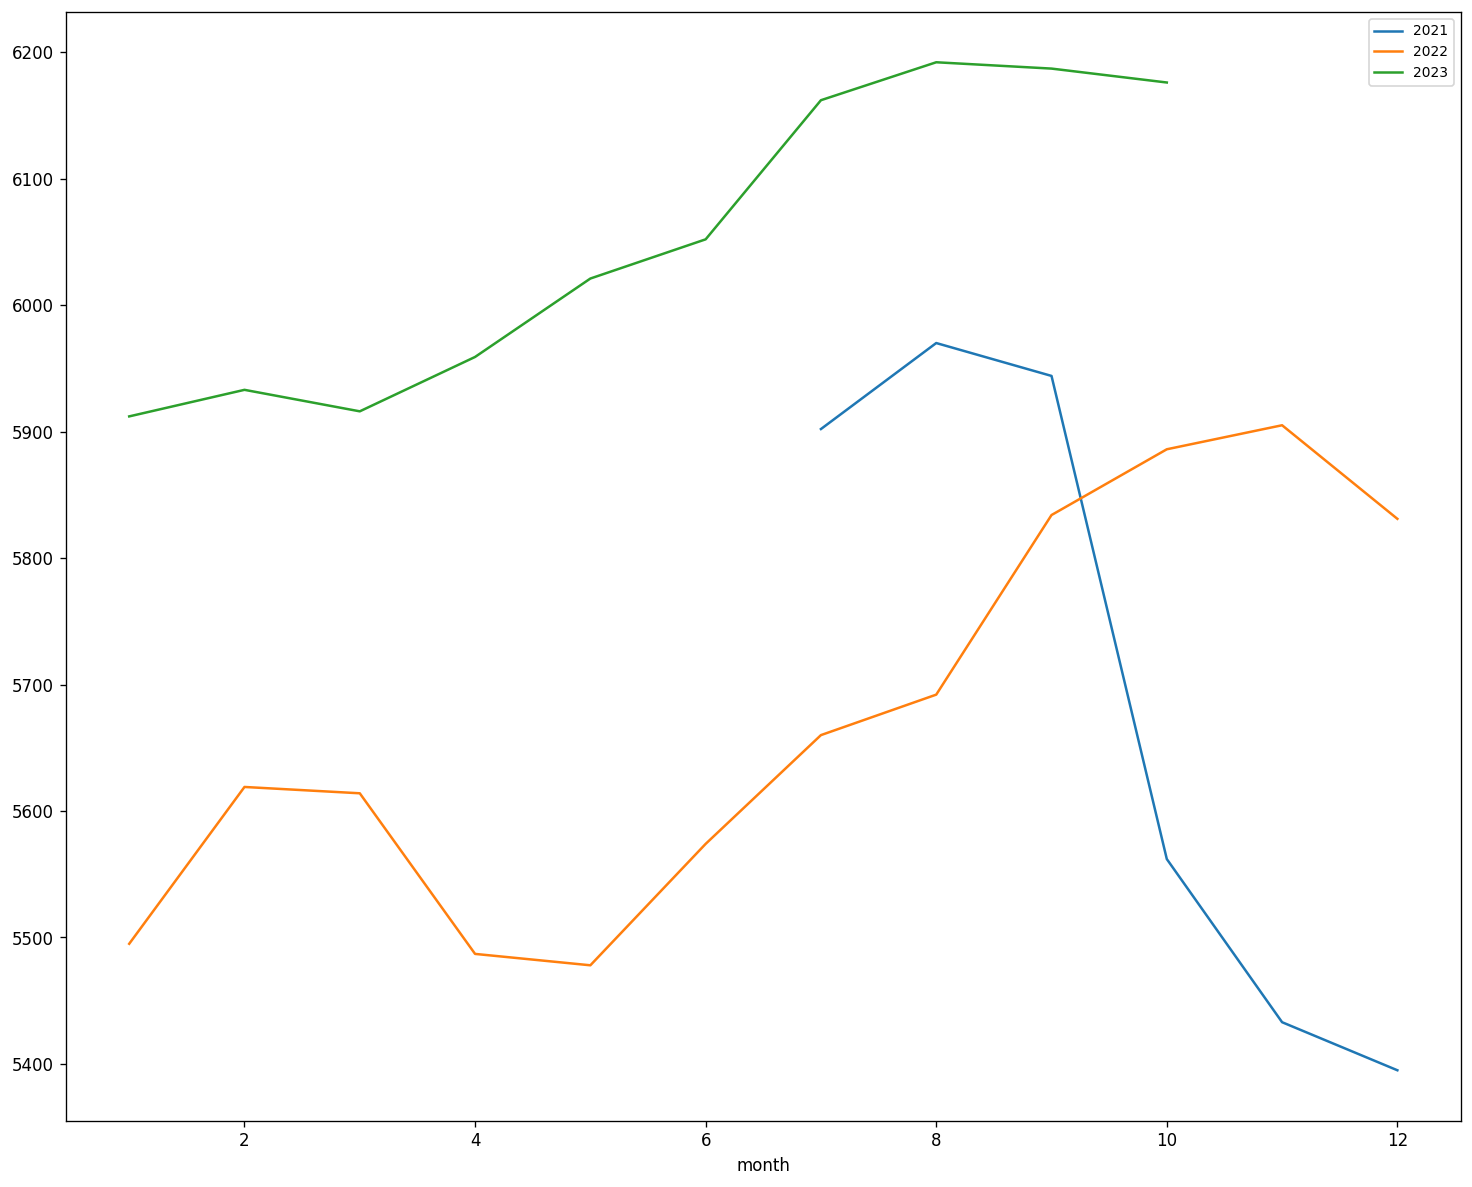

In [19]:
data_to_plot = monthly_avg.pivot(values = 'population',
                              index = 'month',
                              columns = 'year')
#data_to_plot
fig = plt.figure(figsize = (15, 12))
data_to_plot.plot(ax = fig.add_subplot(111))
plt.legend(loc=1, fontsize = 'small')
plt.show()


It is evident this timeseries is not stationary, based on the trend line in Step 1 and the yearly graphic above. Let's make sure this is statistically true by running and ADF test.

In [23]:
result = adfuller(monthly_avg['population'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.596158
p-value: 0.871848
Critical Values:
	1%: -3.700
	5%: -2.976
	10%: -2.628


In [22]:
result = adfuller(monthly_avg['population'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.672164
p-value: 0.004522
Critical Values:
	1%: -3.770
	5%: -3.005
	10%: -2.643


Text(0.5, 1.0, 'Autocorrelation')

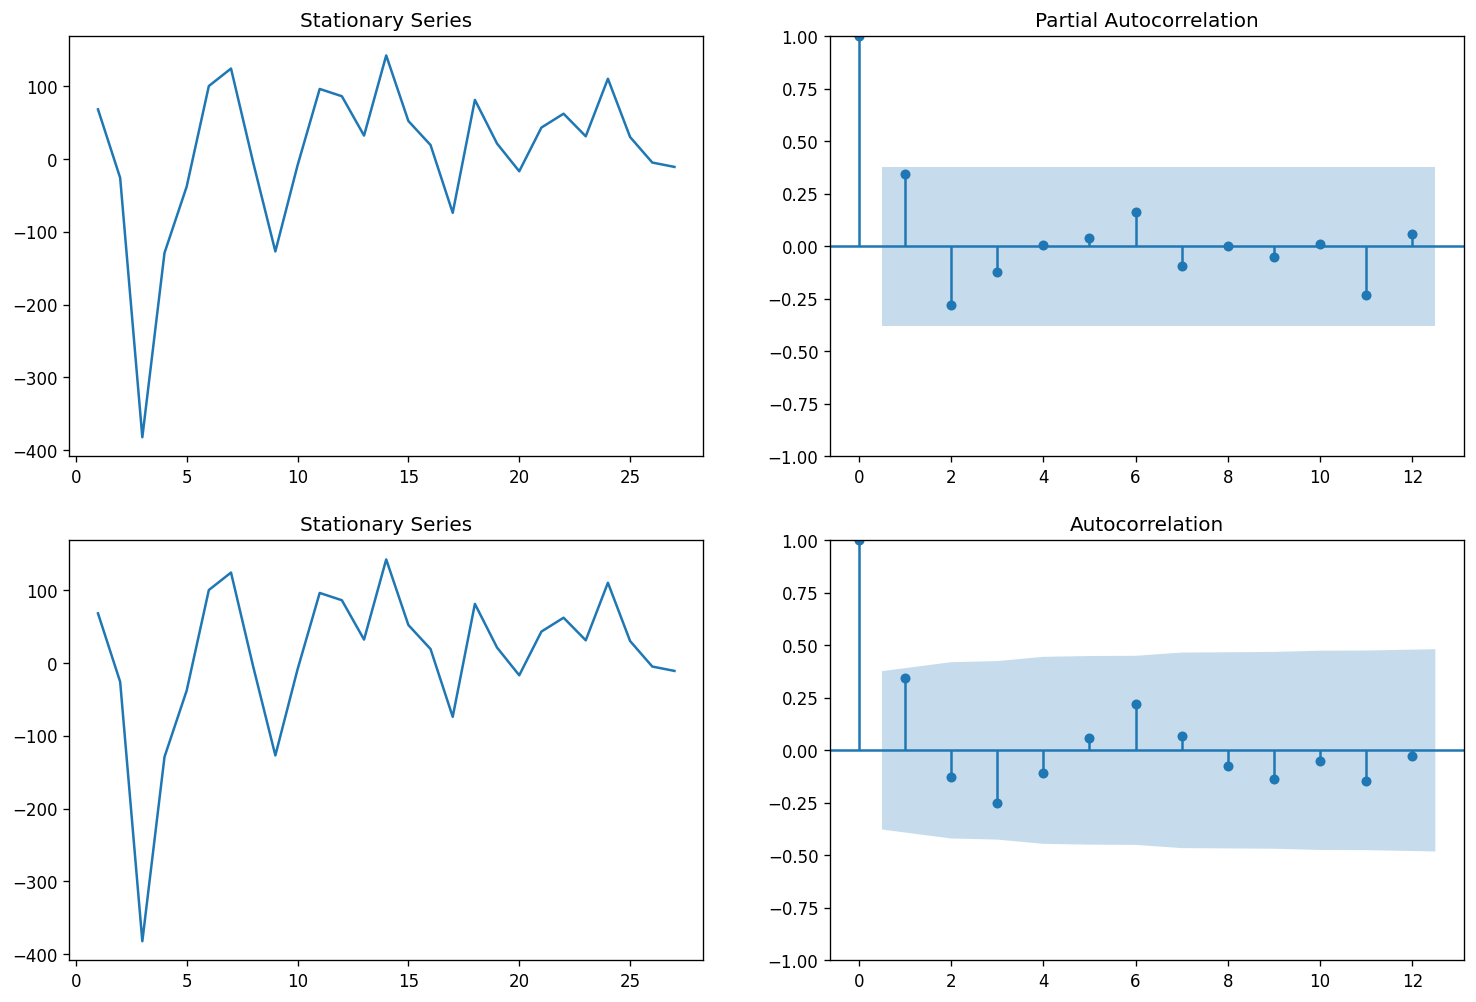

In [27]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# PACF
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(monthly_avg['population'].diff()); axes[0, 0].set_title('Stationary Series')

# axes[0, 0].plot(post_SHO['Gain/Loss']); axes[0, 0].set_title('Original Series')
plot_pacf(monthly_avg['population'].diff().dropna(), ax=axes[0, 1], lags = 12)
axes[0, 1].set_title('Partial Autocorrelation')

# ACF
axes[1, 0].plot(monthly_avg['population'].diff()); axes[1, 0].set_title('Stationary Series')
# axes[1, 0].plot(post_SHO['Gain/Loss']); axes[1, 0].set_title('Original Series')
plot_acf(monthly_avg['population'].diff().dropna(), ax=axes[1, 1], lags = 12)
axes[1, 1].set_title('Autocorrelation')

Based on the above results from adfuller test, the time-series is not stationary, so we should consider ARIMA model with $d = 1$ or first-order differencing. Based on the PACF and ACF, we should consider adding a AR term of 1. Thus, lets fit an ARIMA(Q, D, P) = ARIMA(1,1,0).

Recall that:

* **p:** The size of the moving average window, or the number of the moving average terms, also called the order of moving average.

* **q:** The number of AR terms included in the model, also called the lag order.

### Step 4: Fit the model to parameters

In [30]:
P = 0
D = 1
Q = 1

# fit model
series = monthly_avg['population'].reset_index(drop = True)

# model = sm.tsa.SARIMAX(series,order=(Q,D,P),seasonal_order=(Q,D,P,12))
model = sm.tsa.ARIMA(series, order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             population   No. Observations:                   28
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -161.500
Date:                Wed, 01 Nov 2023   AIC                            327.000
Time:                        14:53:23   BIC                            329.592
Sample:                             0   HQIC                           327.771
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3514      0.541      0.650      0.516      -0.709       1.411
sigma2      9202.4352   1456.302      6.319      0.000    6348.135    1.21e+04
Ljung-Box (L1) (Q):                   0.29   Jarque-

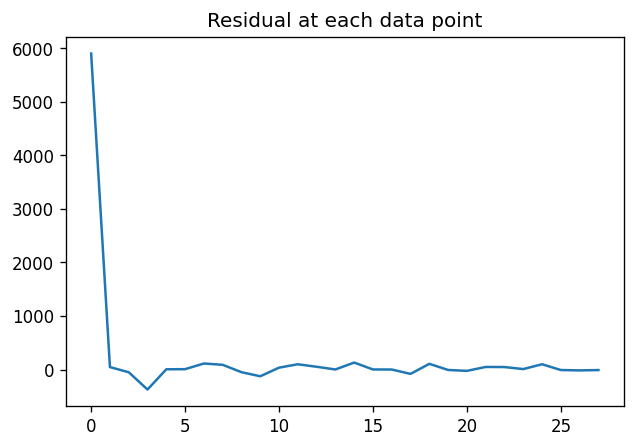

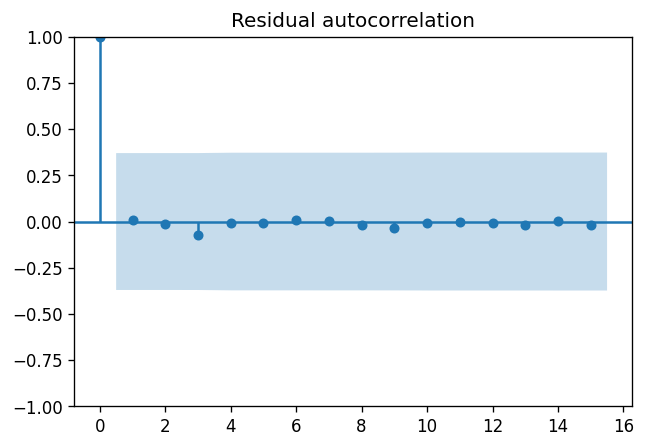

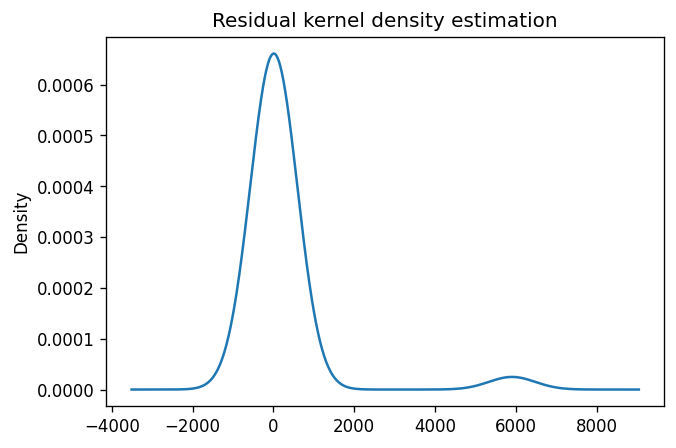

                 0
count    28.000000
mean    216.225110
std    1118.390236
min    -372.863605
25%     -10.817749
50%       6.282647
75%      61.414220
max    5902.000000
p value is  2.1499781834478004e-15
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
    lb_stat  lb_pvalue
1  0.001284   0.971419
2  0.007204   0.996404
3  0.181687   0.980490
4  0.183919   0.996022
5  0.186410   0.999253


In [31]:
#check residuals
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

In [36]:
# Forecast
n_steps = 12
fcast = model_fit.forecast(steps = n_steps)  # 95% conf
fc = model_fit.get_forecast(steps = n_steps).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(len(series),len(series)+n_steps))
lower_series = pd.Series(fc.mean_ci_lower, index=range(len(series),len(series)+n_steps))
upper_series = pd.Series(fc.mean_ci_upper, index=range(len(series),len(series)+n_steps))

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


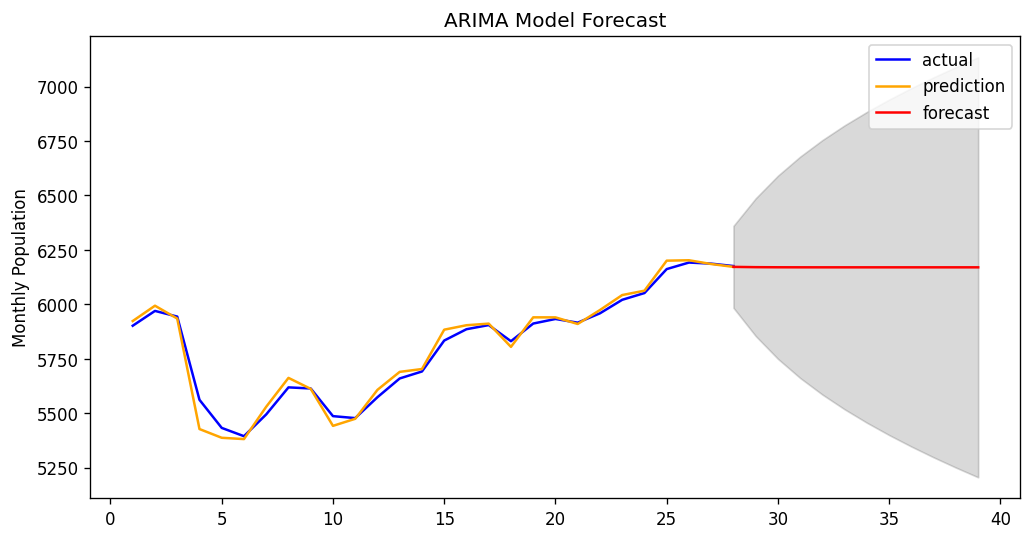

In [37]:
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index+1,series,
        color='blue',label='actual') # in-sample
ax.plot(series.index+1,model_fit.predict(start=1,end=len(series),dynamic=False,typ='levels'),
        color='orange',label='prediction') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.ylabel('Monthly Population')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

### Step 5: Tune model

In [38]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Convert the 'Year-Mo' column to datetime
monthly_avg['Year-Mo'] = pd.to_datetime(monthly_avg['Year-Mo'])
train_data = monthly_avg[monthly_avg['year'] < 2023]
test_data = monthly_avg[monthly_avg['year'] >= 2023]
# Set the 'Year-Mo' column as the index
train_data.set_index('Year-Mo', inplace=True)

# Select only the 'Gain/Loss' column for modeling
train_series = train_data['population']
test_series = test_data['population']

In [39]:
print(len(train_series),len(test_series))

18 10


In [43]:
# Define the range of parameters to search
p_values = range(0, 4)  # AutoRegressive (AR) component
d_values = range(0, 2)  # Integrated (I) component
q_values = range(0, 4)  # Moving Average (MA) component

best_mse = float('inf')
best_order = None

# Iterate over all possible combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            if order != (0, 0, 0):  # Exclude the order (0, 0, 0)
                try:
                    # Fit the ARIMA model
                    model = ARIMA(train_series, order=order)
                    model_fit = model.fit(method_kwargs={'warn_convergence': False})

                    # Perform out-of-sample forecast for 2023
                    forecast = model_fit.get_forecast(steps=len(test_series))
                    forecast_values = forecast.predicted_mean

                    # Calculate the Mean Squared Error (MSE)
                    mse = mean_squared_error(test_series, forecast_values)

                    # Check if the current MSE is the best so far
                    if mse < best_mse:
                        best_mse = mse
                        best_order_MSE = order
                    print(order, mse)

                except:
                    continue


# Print the best parameters and corresponding MSE
print("Best ARIMA order:", best_order_MSE)
print("Best MSE:", best_mse)

(0, 0, 1) 142023.42755487267
(0, 0, 2) 139980.5528927599
(0, 0, 3) 158092.89543399675
(0, 1, 0) 61115.8
(0, 1, 1) 77362.47067287951
(0, 1, 2) 88884.44585454965
(0, 1, 3) 145716.94807848628
(1, 0, 0) 97651.57468179041
(1, 0, 1) 118925.42429903173
(1, 0, 2) 139849.9103338797
(1, 0, 3) 154526.82380654002
(1, 1, 0) 81184.13089173622
(1, 1, 1) 81144.34337328449
(1, 1, 2) 118132.5684500233
(1, 1, 3) 145656.59121662873
(2, 0, 0) 162966.58182023518
(2, 0, 1) 164925.0989876787
(2, 0, 2) 134086.47643925852
(2, 0, 3) 171247.35346127048
(2, 1, 0) 72662.60571931934
(2, 1, 1) 168194.16070190066
(2, 1, 2) 65884.54874087192
(2, 1, 3) 137189.39947893846
(3, 0, 0) 165507.58244320203
(3, 0, 1) 163220.64545936434
(3, 0, 2) 159302.35692869645
(3, 0, 3) 205519.4675492003
(3, 1, 0) 73106.79443727917
(3, 1, 1) 67974.76361660114
(3, 1, 2) 70537.28792300452
(3, 1, 3) 152418.87749166132
Best ARIMA order: (0, 1, 0)
Best MSE: 61115.8


In [45]:
#Define the range of parameters to search
p_values = range(0, 4)  # AutoRegressive (AR) component
d_values = range(0, 2)  # Integrated (I) component
q_values = range(0, 4)  # Moving Average (MA) component

best_aic = float('inf')
best_order = None

# Iterate over all possible combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            if order != (0, 0, 0):  # Exclude the order (0, 0, 0)
                try:
                    # Fit the ARIMA model
                    model = ARIMA(train_series, order=order)
                    model_fit = model.fit(method_kwargs={'warn_convergence': False})

                    # Calculate the AIC
                    aic = model_fit.aic

                    # Check if the current AIC is the best so far
                    if aic < best_aic:
                        best_aic = aic
                        best_order_aic = order

                except:
                    continue

# Print the best parameters and corresponding AIC
print("Best ARIMA order:", best_order_aic)
print("Best AIC:", best_aic)

Best ARIMA order: (3, 1, 0)
Best AIC: 211.5314881531334


In [46]:
N = len(train_series)
order_mse = best_order_MSE
order_aic = best_order_aic
# Fit the ARIMA model
model_mse = ARIMA(train_series, order=order_mse)
model_mse_fit = model_mse.fit(method_kwargs={'warn_convergence': False})

# Perform in-sample predictions
train_predictions = model_mse_fit.predict()

# Perform out-of-sample forecast for 2023
fcast_mse = model_mse_fit.forecast(steps=len(test_series))
forecast_mse = model_mse_fit.get_forecast(steps=len(test_series)).summary_frame() #get conf interval
fc_series = pd.Series(forecast_mse['mean'].values, index=range(N,len(monthly_avg)))
lower_series = pd.Series(forecast_mse.mean_ci_lower.values, index=range(N,len(monthly_avg)))
upper_series = pd.Series(forecast_mse.mean_ci_upper.values, index=range(N,len(monthly_avg)))

model_aic = ARIMA(train_series, order=order_aic)
model_aic_fit = model_aic.fit(method_kwargs={'warn_convergence': False})

# Perform in-sample predictions
train_predictions_aic = model_aic_fit.predict()

# Perform out-of-sample forecast for 2023
fcast_aic = model_aic_fit.forecast(steps=len(test_series))
forecast_aic = model_aic_fit.get_forecast(steps=len(test_series)).summary_frame() #get conf interval
fc_series_aic = pd.Series(forecast_aic['mean'].values, index=range(N,len(monthly_avg)))
lower_series_aic = pd.Series(forecast_aic.mean_ci_lower.values, index=range(N,len(monthly_avg)))
upper_series_aic = pd.Series(forecast_aic.mean_ci_upper.values, index=range(N,len(monthly_avg)))

In [47]:
print(model_mse_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             population   No. Observations:                   18
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -105.931
Date:                Wed, 01 Nov 2023   AIC                            213.863
Time:                        15:15:12   BIC                            214.696
Sample:                    07-01-2021   HQIC                           213.945
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.513e+04   3332.189      4.541      0.000    8599.988    2.17e+04
Ljung-Box (L1) (Q):                   2.67   Jarque-Bera (JB):                11.88
Prob(Q):                              0.10   Pr

In [48]:
print(model_aic_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             population   No. Observations:                   18
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -101.766
Date:                Wed, 01 Nov 2023   AIC                            211.531
Time:                        15:15:21   BIC                            214.864
Sample:                    07-01-2021   HQIC                           211.863
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3384      0.469      0.721      0.471      -0.581       1.258
ar.L2         -0.0472      0.531     -0.089      0.929      -1.088       0.993
ar.L3         -0.5482      0.255     -2.150      0.0

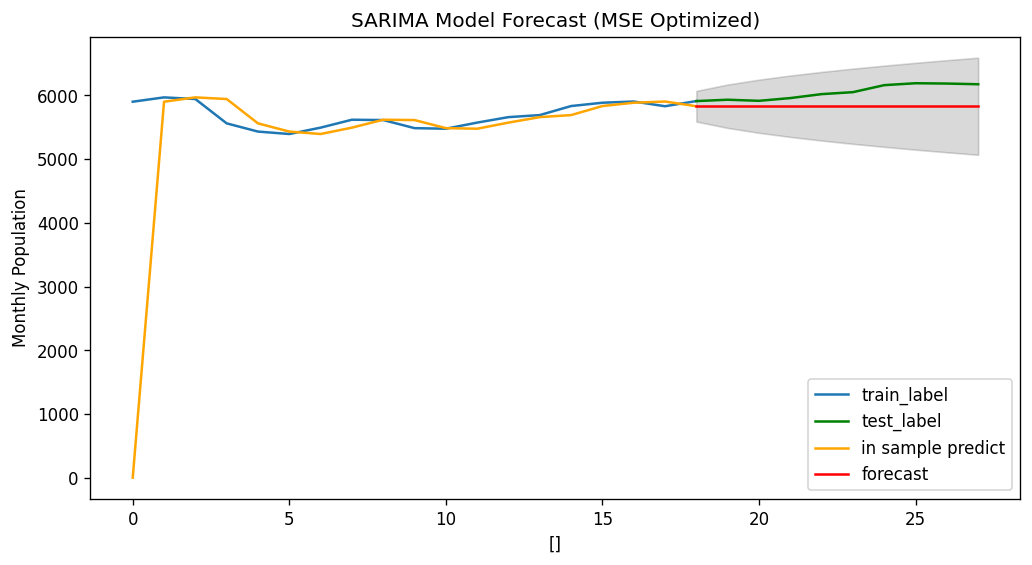

In [50]:
# Plot the data
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(monthly_avg.index[:N+1],monthly_avg[:N+1]['population'],label='train_label') # train
ax.plot(monthly_avg.index[N:],monthly_avg[N:]['population'],color='green',label='test_label') # test
ax.plot(monthly_avg.iloc[:N+1].index,model_mse_fit.predict(start=0,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(monthly_avg.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel([])
plt.ylabel('Monthly Population')
plt.title('SARIMA Model Forecast (MSE Optimized)')
plt.legend()
plt.show()

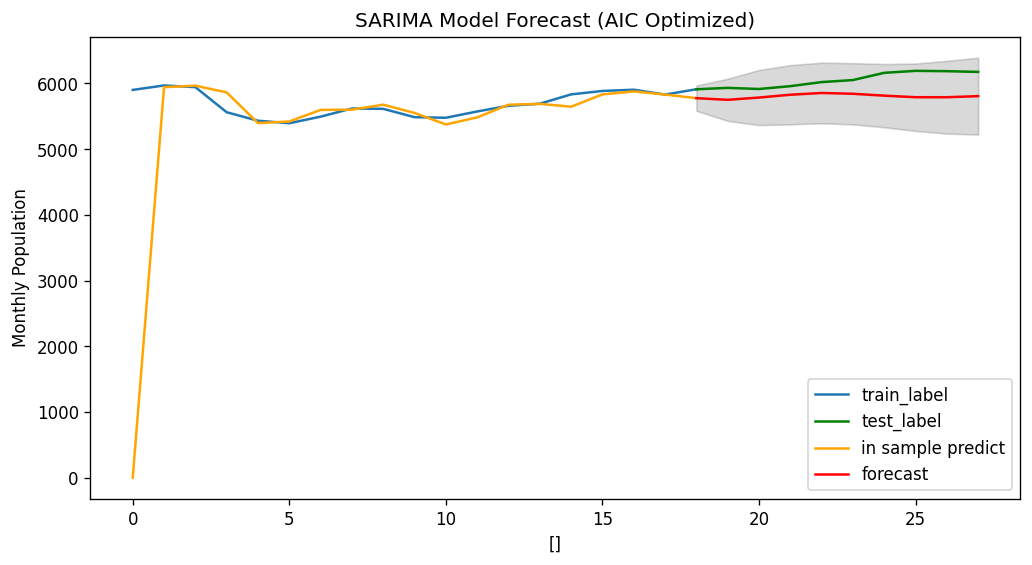

In [51]:
# Plot the data
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(monthly_avg.index[:N+1],monthly_avg[:N+1]['population'],label='train_label') # train
ax.plot(monthly_avg.index[N:],monthly_avg[N:]['population'],color='green',label='test_label') # test
ax.plot(monthly_avg.iloc[:N+1].index,model_aic_fit.predict(start=0,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series_aic, label='forecast', color='red') # forecast
ax.fill_between(monthly_avg.iloc[N:].index, lower_series_aic, upper_series_aic, color='k', alpha=.15) # conf

plt.xlabel([])
plt.ylabel('Monthly Population')
plt.title('SARIMA Model Forecast (AIC Optimized)')
plt.legend()
plt.show()